In [1]:
# all imports
from my_objects import *
from my_objects import ModuleProperties, CombiningModules

In [2]:
def looping_function(num_modules, num_internal_species, num_pins, stoich_matrix):
    
    species_names = []

    for i in range(num_internal_species):
        species_names.append(i+1+num_pins)

    for i in range(num_pins):
        species_names.append(i+1)

    for i in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
        species_names.append(i+1+num_internal_species)

    for i in range(num_pins):
        species_names.append(i+num_internal_species+num_pins+1+(stoich_matrix.shape[1]-num_internal_species-num_pins*2))

    species_grid = [list(species_names)]
    for i in range(num_modules-1):
        prev = species_grid[-1]
        new_species_names = []

        for j in range(num_internal_species):
            new_species_names.append(prev[-1] + 1 + j)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j)

        for j in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
            new_species_names.append(prev[-1] + 1 + j + num_internal_species)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j + num_internal_species + num_pins + (stoich_matrix.shape[1]-num_internal_species-num_pins*2))

        species_grid.append(new_species_names)


    def num_to_code(n):
        n -= 1
        letters = []
        for _ in range(2):
            letters.append(chr(ord('A') + (n % 26)))
            n //= 26
        return ''.join(reversed(letters))

    def convert_2d_array_to_codes(int_grid):
        return [
            [num_to_code(x) for x in row]
            for row in int_grid
        ]

    species_string_grid = convert_2d_array_to_codes(species_grid)

    mod_list = []
    for i in range(num_modules):
        mod_i = ModuleProperties(stoich_matrix, num_internal_species, species_string_grid[i])
        mod_list.append(mod_i)
        
    mod_combined = mod_list[0]
    
    import time
    import statistics

    def time_stats(func, n=1, *args, **kwargs):
        times = []
        for _ in range(n):
            start = time.perf_counter()
            func(*args, **kwargs)
            times.append(time.perf_counter() - start)
        return statistics.mean(times), statistics.stdev(times)

    def combining_all_modules(mod_list, num_modules, mod_combined):
        for i in range(1, num_modules):
            mod_combined = CombiningModules(mod_combined, mod_list[i])
            resis_matrix = mod_combined.calculate_fundamental_resistance_matrix()
        return mod_combined, resis_matrix
    

    mod_combined_properties = combining_all_modules(mod_list, num_modules, mod_combined)[0].module_properties()


    def calculating_reistance_matrix_without_modularity():
        return mod_combined_properties.calculate_fundamental_resistance_matrix()

    modular_mean_combine, modular_std_combine = time_stats(
    lambda: combining_all_modules(mod_list, num_modules, mod_combined), n=2)

    unmodular_mean_combine, unmodular_std_combine = time_stats(
    lambda: calculating_reistance_matrix_without_modularity(), n=2)

    print(f"Modular combining: {modular_mean_combine:.6f} seconds (std: {modular_std_combine:.6f})")
    print(f"Unmodular combining: {unmodular_mean_combine:.6f} seconds (std: {unmodular_std_combine:.6f})")

    return modular_mean_combine, modular_std_combine, unmodular_mean_combine, unmodular_std_combine
    


In [3]:
num_modules = 2
stoich_matrix = Matrix( [[-1,0,-1,-1,0],
                   [1,-1,0,0,0],
                   [0,1,1,0,-1],
                   [0,0,0,1,0],
                   [0,0,0,0,1]] )
num_internal_species = 3
num_pins = 1

looping_function(num_modules, num_internal_species, num_pins, stoich_matrix)

Modular combining: 0.054539 seconds (std: 0.051884)
Unmodular combining: 0.027707 seconds (std: 0.013434)


In [4]:
modular_mean_times = []
unmodular_mean_times = []
modular_std_times = []
unmodular_std_times = []
max_num_modules = 5
list_of_i = []
for i in range(max_num_modules):
    if i<1:
        continue
    print(i+1)
    list_of_i.append(i+1)
    modular_mean_time, modular_std_time, unmodular_mean_time, unmodular_std_time = looping_function(i+1, num_internal_species, num_pins, stoich_matrix)
    modular_mean_times.append(modular_mean_time)
    unmodular_mean_times.append(unmodular_mean_time)
    modular_std_times.append(modular_std_time)
    unmodular_std_times.append(unmodular_std_time)



2
Modular combining: 0.018205 seconds (std: 0.001118)
Unmodular combining: 0.016697 seconds (std: 0.000573)
3
Modular combining: 0.043410 seconds (std: 0.001769)
Unmodular combining: 0.195492 seconds (std: 0.031169)
4
Modular combining: 0.089789 seconds (std: 0.004420)
Unmodular combining: 2.698958 seconds (std: 0.101642)
5
Modular combining: 0.146725 seconds (std: 0.000148)
Unmodular combining: 57.361202 seconds (std: 1.922016)


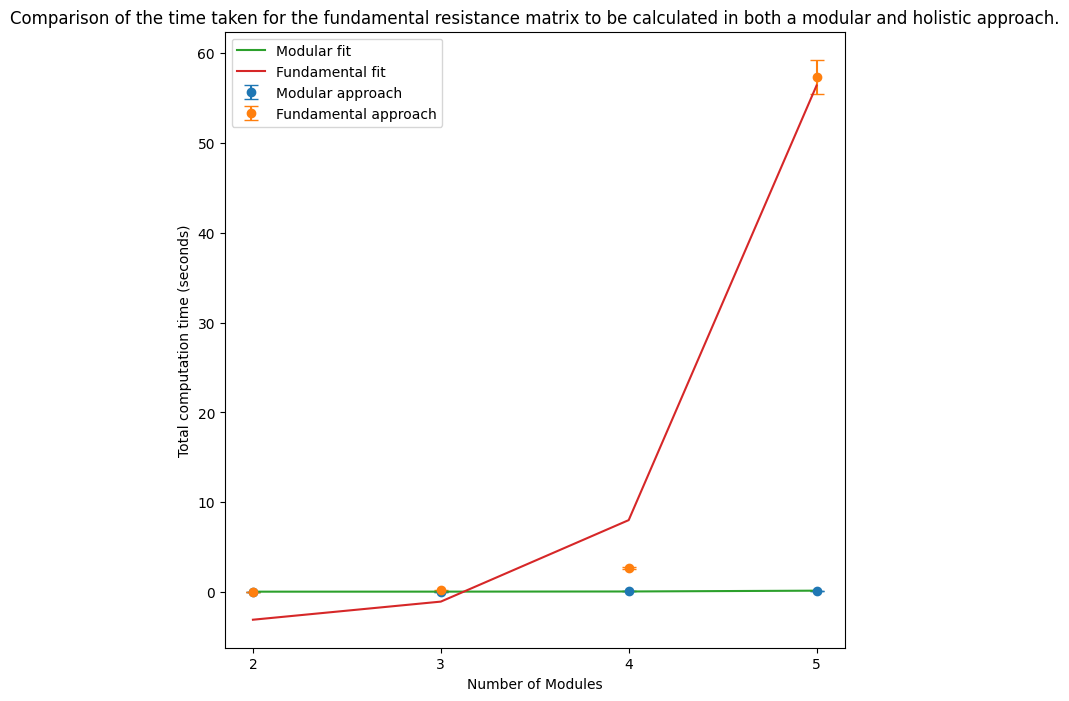

In [5]:

import matplotlib.pyplot as plt
plt.errorbar(list_of_i, modular_mean_times, yerr=modular_std_times, fmt='o', capsize=5, label="Modular approach")
plt.errorbar(list_of_i, unmodular_mean_times, yerr=unmodular_std_times, fmt='o', capsize=5, label = "Fundamental approach")
plt.xticks(list_of_i)

plt.xlabel("Number of Modules")
plt.ylabel("Total computation time (seconds)")
plt.title("Comparison of the time taken for the fundamental resistance matrix to be calculated in both a modular and holistic approach.")

# import numpy as np

# logx = np.log10(list_of_i)
# logy_modular = np.log10(modular_mean_times)
# logy_unmodular = np.log10(unmodular_mean_times)

# fit_modular = np.polyfit(logx, logy_modular, 1)
# fit_unmodular = np.polyfit(logx, logy_unmodular, 1)

# plt.plot(list_of_i, 10**(fit_modular[0]*logx + fit_modular[1]), label="Modular fit")
# plt.plot(list_of_i, 10**(fit_unmodular[0]*logx + fit_unmodular[1]), label="Fundamental fit")

# print(f"Modular fit: y = {10**fit_modular[1]:.2e} * x^{fit_modular[0]:.2f}")
# print(f"Fundamental fit: y = {10**fit_unmodular[1]:.2e} * x^{fit_unmodular[0]:.2f}")

from scipy.special import factorial
from scipy.optimize import curve_fit   

def factorial_func(x, a, b):
    return a * factorial(x) + b
popt_modular, _ = curve_fit(factorial_func, list_of_i, modular_mean_times)
popt_unmodular, _ = curve_fit(factorial_func, list_of_i, unmodular_mean_times)

plt.plot(list_of_i, factorial_func(np.array(list_of_i), *popt_modular), label="Modular fit")
plt.plot(list_of_i, factorial_func(np.array(list_of_i), *popt_unmodular), label="Fundamental fit")

# plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
#### CHANGE AND RENAME THIS STUFF FOR A BETTER SCALING ANALYSIS


def looping_function(num_modules, num_internal_species, num_pins, stoich_matrix):
    
    species_names = []

    for i in range(num_internal_species):
        species_names.append(i+1+num_pins)

    for i in range(num_pins):
        species_names.append(i+1)

    for i in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
        species_names.append(i+1+num_internal_species)

    for i in range(num_pins):
        species_names.append(i+num_internal_species+num_pins+1+(stoich_matrix.shape[1]-num_internal_species-num_pins*2))

    species_grid = [list(species_names)]
    for i in range(num_modules-1):
        prev = species_grid[-1]
        new_species_names = []

        for j in range(num_internal_species):
            new_species_names.append(prev[-1] + 1 + j)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j)

        for j in range(stoich_matrix.shape[1]-num_internal_species-num_pins*2):
            new_species_names.append(prev[-1] + 1 + j + num_internal_species)

        for j in range(num_pins):
            new_species_names.append(prev[-1] + j + num_internal_species + num_pins + (stoich_matrix.shape[1]-num_internal_species-num_pins*2))

        species_grid.append(new_species_names)


    def num_to_code(n):
        n -= 1
        letters = []
        for _ in range(2):
            letters.append(chr(ord('A') + (n % 26)))
            n //= 26
        return ''.join(reversed(letters))

    def convert_2d_array_to_codes(int_grid):
        return [
            [num_to_code(x) for x in row]
            for row in int_grid
        ]

    species_string_grid = convert_2d_array_to_codes(species_grid)

    mod_list = []
    for i in range(num_modules):
        mod_i = ModuleProperties(stoich_matrix, num_internal_species, species_string_grid[i])
        mod_list.append(mod_i)
        
    mod_combined = mod_list[0]
    
    import time
    import statistics

    def time_stats(func, n=1, *args, **kwargs):
        times = []
        for _ in range(n):
            start = time.perf_counter()
            func(*args, **kwargs)
            times.append(time.perf_counter() - start)
        return statistics.mean(times), statistics.stdev(times)

    def combining_all_modules(mod_list, num_modules, mod_combined):
        for i in range(1, num_modules):
            mod_combined = CombiningModules(mod_combined, mod_list[i])
            resis_matrix = mod_combined.calculate_fundamental_resistance_matrix()
        return mod_combined, resis_matrix
    

    mod_combined_properties = combining_all_modules(mod_list, num_modules, mod_combined)[0].module_properties()


    # def calculating_reistance_matrix_without_modularity():
        # return mod_combined_properties.calculate_fundamental_resistance_matrix()

    modular_mean_combine, modular_std_combine = time_stats(
    lambda: combining_all_modules(mod_list, num_modules, mod_combined), n=2)

    # unmodular_mean_combine, unmodular_std_combine = time_stats(
    # lambda: calculating_reistance_matrix_without_modularity(), n=2)

    print(f"Modular combining: {modular_mean_combine:.6f} seconds (std: {modular_std_combine:.6f})")
    # print(f"Unmodular combining: {unmodular_mean_combine:.6f} seconds (std: {unmodular_std_combine:.6f})")

    return modular_mean_combine, modular_std_combine, None, None
    


2
Modular combining: 0.018142 seconds (std: 0.000498)
3
Modular combining: 0.040568 seconds (std: 0.000483)
4
Modular combining: 0.085398 seconds (std: 0.001387)
5
Modular combining: 0.136612 seconds (std: 0.001356)
6
Modular combining: 0.219746 seconds (std: 0.009490)
7
Modular combining: 0.352857 seconds (std: 0.042663)
8
Modular combining: 0.437173 seconds (std: 0.002093)
9
Modular combining: 0.599479 seconds (std: 0.027511)
10
Modular combining: 0.776875 seconds (std: 0.011301)
11
Modular combining: 0.984477 seconds (std: 0.007432)
12
Modular combining: 1.313380 seconds (std: 0.107954)
13
Modular combining: 1.543135 seconds (std: 0.013519)
14
Modular combining: 1.883291 seconds (std: 0.012998)
15
Modular combining: 2.316977 seconds (std: 0.083719)
16
Modular combining: 2.664444 seconds (std: 0.000490)
17
Modular combining: 3.197377 seconds (std: 0.057080)
18
Modular combining: 3.842258 seconds (std: 0.001821)
19
Modular combining: 4.381626 seconds (std: 0.100166)
20
Modular combini

([<matplotlib.axis.XTick at 0x131e92030>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

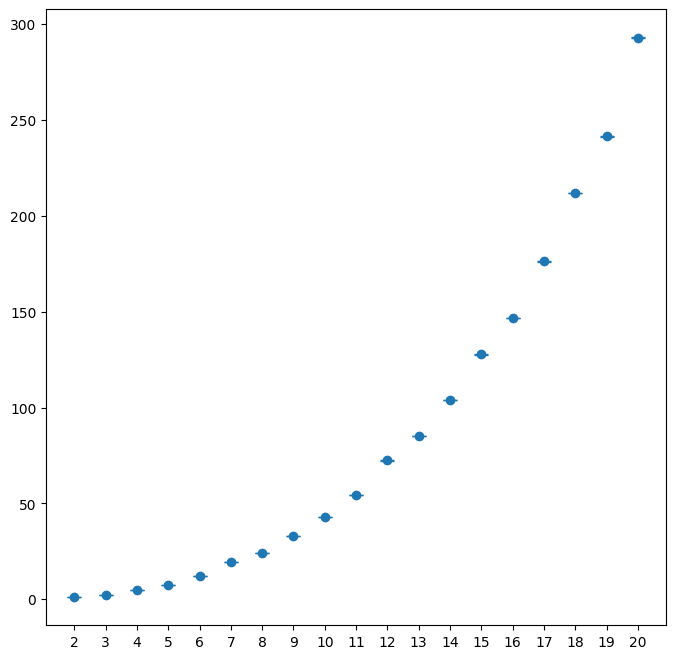

In [15]:
modular_mean_times = []

modular_std_times = []

max_num_modules = 20
list_of_i = []
for i in range(max_num_modules):
    if i<1:
        continue
    print(i+1)
    list_of_i.append(i+1)
    modular_mean_time, modular_std_time, unmodular_mean_time, unmodular_std_time = looping_function(i+1, num_internal_species, num_pins, stoich_matrix)
    modular_mean_times.append(modular_mean_time)
    modular_std_times.append(modular_std_time)

modular_mean_times = np.array(modular_mean_times)
plt.errorbar(list_of_i, modular_mean_times/modular_mean_times[0], yerr=modular_std_times, fmt='o', capsize=5, label = "modular approach")
plt.xticks(list_of_i)


In [7]:
modular_mean_times[-1]/modular_mean_times[-2]

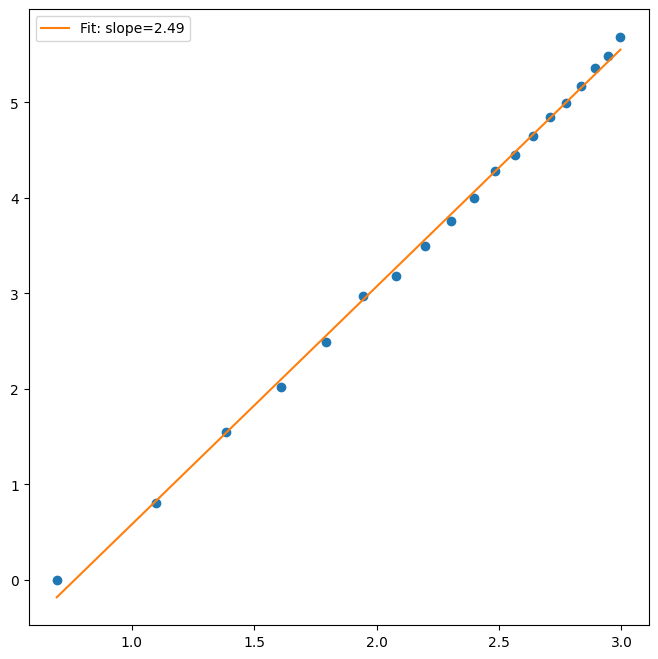

In [24]:
y = np.log(modular_mean_times/modular_mean_times[0])
x = np.log(list_of_i)

pfit = np.polyfit(x, y, 1)

plt.plot(x,y, 'o')
plt.plot(x, pfit[0]*x + pfit[1], label=f"Fit: slope={pfit[0]:.2f}")
plt.legend()

In [8]:
unmodular_mean_times[-1]/unmodular_mean_times[-2]

In [10]:
import time
start= time.time()
looping_function(6, num_internal_species, num_pins, stoich_matrix)
end = time.time()
total_n6 = end - start
print(f"Total time for 6 modules: {total_n6:.6f} seconds")

KeyboardInterrupt: 